<h1 style="color: navy bleu;text-align:center"> Rendu du TP de Deep Learning "Comparaisons des modèles RNN"

<h3 style="color: navy bleu"> Saïda Guezoui, groupe DS</h3>

<h3 style="color: navy bleu"> Introduction 

Dans ce tp, on cherche à comparer différents modèles RNN (RNN simple, GRU et LSTM) sur la prédiction du cours de la bourse de l'entreprise IBM. 

Dans un premier temps, on commence par étudier et préparer les données pour l'apprentissage et le test de nos réseaux de neurones. Puis, nous testerons nos modèles avec des configurations différentes. Nous essaierons ensuite de mettre en place un protocole pour déterminer qu'elle est la famille de modèles la plus performante.

Dans une dernière, nous essaierons de prédire le cours de la bourse sur une semaine entière.

<h3 style="color: navy bleu"> Importation des bibliothèques nécessaires </h3>

In [43]:
# Mathématiques et affichage
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

<h2 style="color: navy bleu"> I. Analyse et traitements des données

<h3 style="color: navy bleu">  1. Importation 


In [44]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

print(f"Nombre d'observations et nombre de colonnes : {dataset.shape}\n")
print(f"Observations : {dataset.index[0]} / {dataset.index[1]} / ... / {dataset.index[-1]}\n")

dataset.head()

Nombre d'observations et nombre de colonnes : (3020, 6)

Observations : 2006-01-03 00:00:00 / 2006-01-04 00:00:00 / ... / 2017-12-29 00:00:00



,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


Nous avons donc un jeu de données contenant 3020 jours d'observation - allant du 3 janvier 2006 au 29 septembre 2017 - avec 5 mesures : Open, High, Low, Close et Volume.

<h3 style="color: navy bleu"> 2. Représentation graphique des données


In [45]:
def display_plot(plots, colors, legends, title):
    # Mise en forme et affichage de la grille
    plt.figure(figsize=(15,5)) ; plt.grid()
    
    # On trace les courbes
    for i in range(len(plots)):
        plt.plot(plots[i], color = colors[i])
        
    # On affiche le titre et les légendes
    plt.title(title) ; plt.legend(legends)
    
    plt.show()

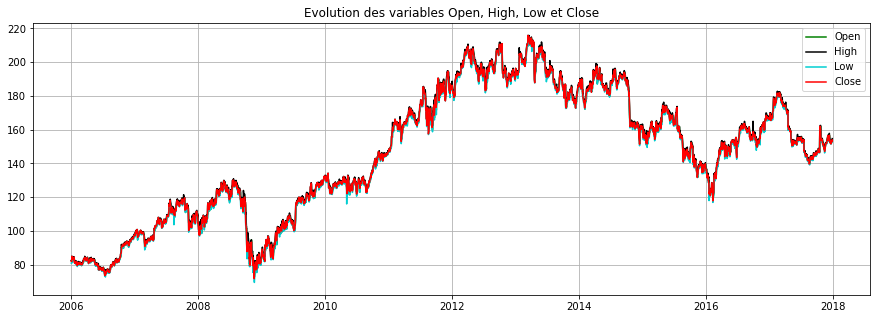

In [46]:
plots   = [dataset["Open"], dataset["High"], dataset["Low"], dataset["Close"]]
colors  = ["green","black", "darkturquoise", "red"]
legends = ["Open", "High", "Low", "Close"]
title   = "Evolution des variables Open, High, Low et Close"

display_plot(plots, colors, legends, title)

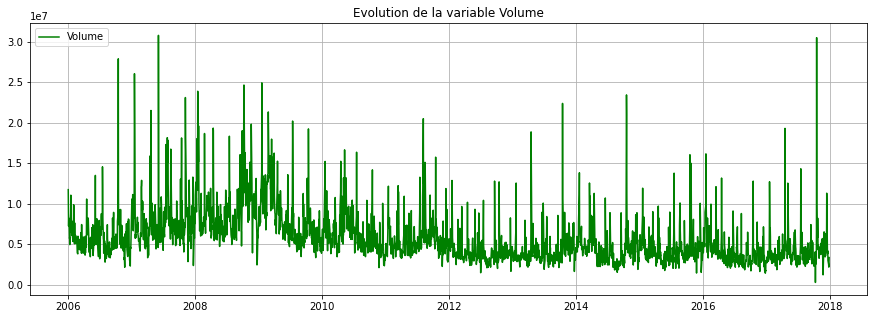

In [47]:
display_plot([dataset["Volume"]], ["green"], ["Volume"], "Evolution de la variable Volume")

**Remarque** : Il y a une différence remarquable entre la variable volume et les autres. Ici, ne s'intéresse pas à la variable "volume". En revanche, les autres variables suivent une même tendance, nous pouvons donc choisir de se focaliser sur une seule d'entre elles : la variable High.

<h3 style="color: navy bleu"> 3. Préparation de notre jeu de données

Dans cette partie, on cherche à construire nos données d'apprentissage et de validation. En commence par diviser nos jeu en deux partie : une pour l'entraînement et l'autre pour le test. Ensuite, on normalise les données entre 0 et 1. Enfin, on peut construire notre jeu de données de la façon suivante : pour chaque jour à prédire, on donne en entrée de notre réseaux de neurones la valeur des 60 derniers jours du cours de la bourse.

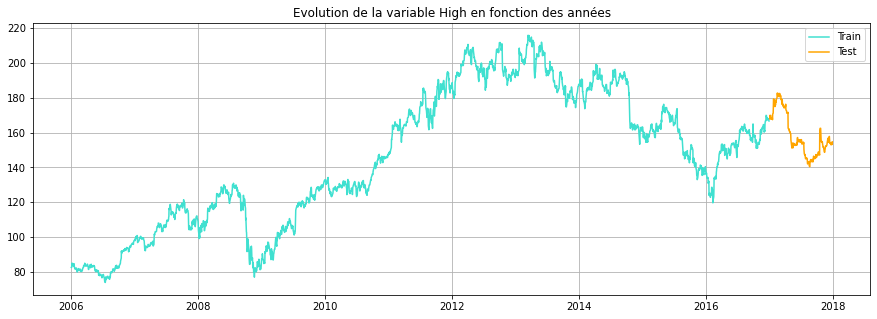

In [48]:
# On divise notre jeu de données en deux entre 2006-2016 et 2017-2018
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set     = dataset["2017":].iloc[:,1:2].values

# On affiche les deux courbes
courbes = [dataset["High"][:"2016"],dataset["High"]["2017":]]
display_plot(courbes,["turquoise","orange"], ["Train", "Test"], "Evolution de la variable High en fonction des années")

In [51]:
# Normalisation de nos données d'entraînement
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

In [52]:
def build_dataset(dataset, step = 60):
    X_train = [] ; y_train = []
    
    for i in range(step, dataset.shape[0]):
        X_train.append(dataset[i - step:i,0])
        y_train.append(dataset[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train, y_train

In [53]:
X_train, y_train = build_dataset(training_set_scaled)
X_test, y_test   = build_dataset(test_set_scaled)

# Remodelage de X_train pour une modélisation efficace
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

<h2 style="color: navy bleu"> II. Préparation de notre jeu de données Premiers tests avec les modèles RNN

<h3 style="color: navy bleu"> 1. Constructeur de nos réseaux de neurones


Nous allons commencer par définir un constructeur pour nos modèles. Cela nous permettra de changer facilement les paramètres et la structure de nos réseaux de neurones.

<h3 style="color: navy bleu"> a. Constructeur d'un réseau de neurones RNN

In [54]:
def build_RNN(X_train, y_train, units_RNN = [128], optimizer = "adam", epochs = 5):
    # Construction de notre modèle
    model = Sequential()
    
    # Ajout des couches SimpleRNN
    if len(units_RNN) > 1:
        model.add(SimpleRNN(units = units_RNN[0], return_sequences=True, input_shape = (X_train.shape[1],1)))
        
        for i in range(1,len(units_RNN)-1):
            model.add(SimpleRNN(units = units_RNN[i], return_sequences=True))
            
        model.add(SimpleRNN(units = units_RNN[-1]))
    else:
        model.add(SimpleRNN(units = units_RNN[0], input_shape = (X_train.shape[1],1)))
           
    # Ajout de la couche Dense
    model.add(Dense(units = 1))
    
    # Compilation
    model.compile(loss='mse', optimizer = optimizer, metrics=['accuracy'])
    
    # Apprentissage
    model.fit(X_train, y_train, epochs = epochs)
    
    return model

<h3 style="color: navy bleu"> b. Constructeur d'un réseau de neurones GRU

In [55]:
def build_GRU(X_train, y_train, units_GRU = [128], optimizer = "adam", epochs = 5):
    # Construction de notre modèle
    model = Sequential()
    
    # Ajout des couches SimpleRNN
    if len(units_GRU) > 1:
        model.add(GRU(units = units_GRU[0], return_sequences=True, input_shape = (X_train.shape[1],1)))
        
        for i in range(1,len(units_GRU)-1):
            model.add(GRU(units = units_GRU[i], return_sequences=True))
            
        model.add(GRU(units = units_GRU[-1]))
    else:
        model.add(GRU(units = units_GRU[0], input_shape = (X_train.shape[1],1)))
           
    # Ajout de la couche Dense
    model.add(Dense(units = 1))
    
    # Compilation
    model.compile(loss='mse', optimizer = optimizer, metrics=['accuracy'])
    
    # Apprentissage
    model.fit(X_train, y_train, epochs = epochs)
    
    return model

<h3 style="color: navy bleu"> c. Constructeur d'un réseau de neurones LSTM

In [56]:
def build_LSTM(X_train, y_train, units_LSTM = [128], optimizer = "adam", epochs = 5):
    # Construction de notre modèle
    model = Sequential()
    
    # Ajout des couches SimpleRNN
    if len(units_LSTM) > 1:
        model.add(LSTM(units = units_LSTM[0], return_sequences=True, input_shape = (X_train.shape[1],1)))
        
        for i in range(1,len(units_LSTM)-1):
            model.add(LSTM(units = units_LSTM[i], return_sequences=True))
            
        model.add(LSTM(units = units_LSTM[-1]))
    else:
        model.add(LSTM(units = units_LSTM[0], input_shape = (X_train.shape[1],1)))
           
    # Ajout de la couche Dense
    model.add(Dense(units = 1))
    
    # Compilation
    model.compile(loss='mse', optimizer = optimizer, metrics=['accuracy'])
    
    # Apprentissage
    model.fit(X_train, y_train, epochs = epochs)
    
    return model

<h3 style="color: navy bleu"> 2. Premiers tests

Commençons avec un premier test : nous définisons trois modèles avec une couche spécifique (SimpleRNN, GRU et LSTM) et une couche dense avec une unique sortie. On définit aussi le même optimisateur, le même nombre d'epochs et le même nombre d'unités pour chaque réseau.

In [58]:
def rmse(test,predicted):
    return math.sqrt(mean_squared_error(test,predicted))

In [61]:
print("Résultat pour RNN")
model_RNN  = build_RNN(X_train, y_train)
print(rmse(y_test,model_RNN.predict(X_test)))

print("Résultat pour GRU")
model_GRU  = build_GRU(X_train, y_train)
print(rmse(y_test,model_GRU.predict(X_test)))

print("Résultat pour LSTM")
model_LSTM = build_LSTM(X_train, y_train)
print(rmse(y_test,model_LSTM.predict(X_test)))

Résultat pour RNN
Epoch 1/5
85/85 [==============================] - 4s 40ms/step - loss: 0.0071 - accuracy: 7.3828e-04
Epoch 2/5
85/85 [==============================] - 4s 49ms/step - loss: 7.1854e-04 - accuracy: 7.3828e-04
Epoch 3/5
85/85 [==============================] - 4s 51ms/step - loss: 6.0767e-04 - accuracy: 7.3828e-04
Epoch 4/5
85/85 [==============================] - 4s 48ms/step - loss: 6.7725e-04 - accuracy: 7.3828e-04
Epoch 5/5
85/85 [==============================] - 4s 43ms/step - loss: 4.8128e-04 - accuracy: 7.3828e-04
0.06474593918691408
Résultat pour GRU
Epoch 1/5
85/85 [==============================] - 6s 44ms/step - loss: 0.0182 - accuracy: 7.3828e-04
Epoch 2/5
85/85 [==============================] - 3s 36ms/step - loss: 3.3930e-04 - accuracy: 7.3828e-04
Epoch 3/5
85/85 [==============================] - 4s 50ms/step - loss: 3.1274e-04 - accuracy: 7.3828e-04
Epoch 4/5
85/85 [==============================] - 6s 70ms/step - loss: 2.9206e-04 - accuracy: 7.3828e-0

Le réseau de neurones avec le moins de perte est le GRU avec environ 0.051 contre 0.64 pour le RNN et 0.069 pour le LSMT. Cependant comme le montre l'affichage suivant, le nombre de paramètres du GRU et du LSMT est bien plus important que pour le SimpleRNN. Le taux de précision est quand à lui équivalent entre les différents modèles.

In [62]:
model_RNN.summary() ; model_GRU.summary() ; model_LSTM.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 128)               16640     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 128)               50304     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_17"

<h3 style="color: navy bleu">  3. Affichage des premières prédictions

In [63]:
# Prédiction des différents modèles
predict_RNN  = model_RNN.predict(X_test)
predict_GRU  = model_GRU.predict(X_test)
predict_LSTM = model_LSTM.predict(X_test)

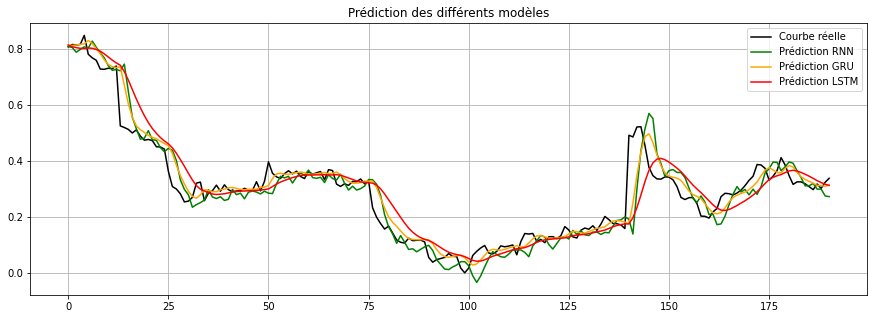

MSE du modèle RNN : 0.06474593918691408
MSE du modèle GRU : 0.05177069941413411
MSE du modèle LSTM : 0.06957526450276424


In [64]:
plots   = [y_test, predict_RNN, predict_GRU, predict_LSTM]
colors  = ["black","green","orange", "red"]
legends = ["Courbe réelle", "Prédiction RNN", "Prédiction GRU", "Prédiction LSTM"]
title   = "Prédiction des différents modèles"

display_plot(plots, colors, legends, title)

# Affichage des mse
def return_rmse(test,predicted):
    return math.sqrt(mean_squared_error(test, predicted))
    
print(f"MSE du modèle RNN : {return_rmse(y_test,predict_RNN)}")
print(f"MSE du modèle GRU : {return_rmse(y_test,predict_GRU)}")
print(f"MSE du modèle LSTM : {return_rmse(y_test,predict_LSTM)}")

<h2 style="color: navy bleu"> III. Etude appronfondie des modèles

Dans cette partie, nous allons essayer de expérimenter des réseaux de neurones avec des hyperparamètres différents.

<h3 style="color: navy bleu"> 1. Impact du nombre de couches sur les résultats

On s'intéresse d'abort à l'impact du nombre de couche dans les résultats. On va entraîner des modèles avec différentes couches et on calcule pour chacun le mse.

In [65]:
units_GRU = [[128],[128,128],[128,128,128]]

for units in units_GRU:
    # Construction et entraînement
    model = build_GRU(X_train, y_train, units_GRU = [128], optimizer = "adam", epochs = 5)
    
    # Prédictions et calcul du mse
    prediction = model.predict(X_test)
    print(f"MSE avec {len(units)} couche(s) : {return_rmse(prediction,y_test)}")

Epoch 1/5
85/85 [==============================] - 8s 64ms/step - loss: 0.0203 - accuracy: 7.3828e-04
Epoch 2/5
85/85 [==============================] - 4s 44ms/step - loss: 3.4534e-04 - accuracy: 7.3828e-04
Epoch 3/5
85/85 [==============================] - 4s 53ms/step - loss: 3.1747e-04 - accuracy: 7.3828e-04
Epoch 4/5
85/85 [==============================] - 5s 61ms/step - loss: 3.0319e-04 - accuracy: 7.3828e-04
Epoch 5/5
85/85 [==============================] - 8s 97ms/step - loss: 2.8861e-04 - accuracy: 7.3828e-04 7s - loss: 2.4120e-04 - accuracy: 0.0000 - ETA: 6s -
MSE avec 1 couche(s) : 0.05120641566906474
Epoch 1/5
85/85 [==============================] - 9s 68ms/step - loss: 0.0113 - accuracy: 7.3828e-04
Epoch 2/5
85/85 [==============================] - 8s 93ms/step - loss: 2.9463e-04 - accuracy: 7.3828e-04 0s - loss: 2.9620e-04 - accuracy: 7.53
Epoch 3/5
85/85 [==============================] - 6s 70ms/step - loss: 2.6964e-04 - accuracy: 7.3828e-04
Epoch 4/5
85/85 [========

On remarque que le nombre de couches identiques n'améliore pas de manière significative les résultats. De plus, le nombre de paramètres augmentent considérablement avec l'ajout de couches. Essayons la même chose en augmentant le nombre d'epochs.

In [66]:
units_GRU = [[128],[128,128],[128,128,128]]

for units in units_GRU:
    # Construction et entraînement
    model = build_GRU(X_train, y_train, units_GRU = [128], optimizer = "adam", epochs = 10)
    
    # Prédictions et calcul du mse
    prediction =model.predict(X_test)
    print(f"MSE avec {len(units)} couche(s) : {return_rmse(prediction,y_test)}")

Epoch 1/10
85/85 [==============================] - 8s 65ms/step - loss: 0.0193 - accuracy: 7.3828e-04 0s - loss: 0.022
Epoch 2/10
85/85 [==============================] - 4s 45ms/step - loss: 3.4543e-04 - accuracy: 7.3828e-04
Epoch 3/10
85/85 [==============================] - 6s 65ms/step - loss: 3.2034e-04 - accuracy: 7.3828e-04
Epoch 4/10
85/85 [==============================] - 6s 72ms/step - loss: 2.9987e-04 - accuracy: 7.3828e-04
Epoch 5/10
85/85 [==============================] - 5s 64ms/step - loss: 2.8816e-04 - accuracy: 7.3828e-04
Epoch 6/10
85/85 [==============================] - 8s 98ms/step - loss: 2.7951e-04 - accuracy: 7.3828e-04
Epoch 7/10
85/85 [==============================] - 7s 87ms/step - loss: 2.6214e-04 - accuracy: 7.3828e-04
Epoch 8/10
85/85 [==============================] - 8s 90ms/step - loss: 2.5945e-04 - accuracy: 7.3828e-04 0s - loss: 2.6337e-04 - 
Epoch 9/10
85/85 [==============================] - 6s 75ms/step - loss: 2.5276e-04 - accuracy: 7.3828e-04

On remarque que le nombre d'epochs permet d'augmenter de manière significative les résultats mais pas le nombre de couches. On peut alors essayer une dernière approche en prenant des couches avec des hyperparamètres différents.

In [60]:
units_GRU = [[128],[128,64],[128,64,32]]

for units in units_GRU:
    # Construction et entraînement
    model = build_GRU(X_train, y_train, units_GRU = [128], optimizer = "adam", epochs = 10)
    
    # Prédictions et calcul du mse
    prediction =model.predict(X_test)
    print(f"MSE avec {len(units)} couche(s) : {return_rmse(prediction,y_test)}")

Epoch 1/10
85/85 [==============================] - 9s 40ms/step - loss: 0.0140 - accuracy: 7.3828e-04
Epoch 2/10
85/85 [==============================] - 3s 39ms/step - loss: 3.1084e-04 - accuracy: 7.3828e-04
Epoch 3/10
85/85 [==============================] - 3s 39ms/step - loss: 2.8923e-04 - accuracy: 7.3828e-04
Epoch 4/10
85/85 [==============================] - 3s 39ms/step - loss: 2.6175e-04 - accuracy: 7.3828e-04
Epoch 5/10
85/85 [==============================] - 3s 39ms/step - loss: 2.5121e-04 - accuracy: 7.3828e-04
Epoch 6/10
85/85 [==============================] - 3s 39ms/step - loss: 2.6126e-04 - accuracy: 7.3828e-04
Epoch 7/10
85/85 [==============================] - 3s 39ms/step - loss: 2.3531e-04 - accuracy: 7.3828e-04
Epoch 8/10
85/85 [==============================] - 3s 39ms/step - loss: 2.2439e-04 - accuracy: 7.3828e-04
Epoch 9/10
85/85 [==============================] - 3s 39ms/step - loss: 2.2081e-04 - accuracy: 7.3828e-04
Epoch 10/10
85/85 [======================

Le réseau avec une seule couche garde encore les meilleurs résultats.

<h3 style="color: navy bleu"> 2. Validation croisée

In [165]:
def builder_RNN(nbr_layers = 3, optimizer = "adam", units = 20):
    """ Constructeur d'un réseau de neurones RNN"""
    model = Sequential()
    
    model.add(SimpleRNN(units = 128, input_shape=(X_train.shape[1],1)))

    model.add(Dense(units = 1))
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [166]:
# Hyperparamètres
OPTIMIZER  = ['rmsprop', 'adam']

param_grid = dict(optimizer = OPTIMIZER)

# Pour rendre notre modèle compatible avec GridSearchCV, on utilise KerasClassifier
model = KerasClassifier(build_fn = builder_RNN)

# Validation croisée
grid = GridSearchCV(estimator = model, param_grid = param_grid)
history = grid.fit(X_train, y_train)

85/85 [==============================] - 4s 9ms/step - loss: 1776375.2500 - accuracy: 3.6914e-04


<h2 style="color: navy bleu"> IV. Prédiction de plusieurs jours


Dans cette dernière partie, on cherche à développer un modèle capable de prédire les valeurs du cours de la bourse sur une semaine. L'idée est de créer un nouveau jeu de données où nos y seront des vecteurs de taille 7 (valeurs des 7 prochains jours). On décide d'augmenter le nombre de jours qui précèdent ceux que l'on veut prédire pour augmenter le nombre de données et faire en sorte que notre réseau de neurones capte les grandes tendances de la semaine. 

In [67]:
def new_build_dataset_RNN(dataset, step = 60):
    X_train = [] ; y_train = []
    
    for i in range(step, dataset.shape[0]-7):
        X_train.append(dataset[i - step:i,0])
        y = []
        for j in range(i, i+7):
            y.append(dataset[j,0])
        y_train.append(y)
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train, y_train

In [68]:
def build_GRU(X_train, y_train, units_GRU = [128], optimizer = "adam", epochs = 5):
    # Construction de notre modèle
    model = Sequential()
    
    # Ajout des couches SimpleRNN
    if len(units_GRU) > 1:
        model.add(GRU(units = units_GRU[0], return_sequences=True, input_shape = (X_train.shape[1],1)))
        
        for i in range(1,len(units_GRU)-1):
            model.add(GRU(units = units_GRU[i], return_sequences=True))
            
        model.add(GRU(units = units_GRU[-1]))
    else:
        model.add(GRU(units = units_GRU[0], input_shape = (X_train.shape[1],1)))
           
    # Ajout de la couche Dense
    model.add(Dense(units = 7))
    
    # Compilation
    model.compile(loss='mse', optimizer = optimizer, metrics=['accuracy'])
    
    # Apprentissage
    model.fit(X_train, y_train, epochs = epochs)
    
    return model

In [94]:
# On applique notre fonction
X_train, y_train = new_build_dataset_RNN(training_set_scaled, step = 14)
X_test, y_test = new_build_dataset_RNN(training_set_scaled, step = 14)


# On modifie la forme de notre matrice
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [83]:
model = build_GRU(X_train, y_train, units_GRU = [128], optimizer = "rmsprop", epochs = 20)

Epoch 1/20
86/86 [==============================] - 5s 29ms/step - loss: 0.0214 - accuracy: 0.2005
Epoch 2/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0036 - accuracy: 0.1827 0s - loss: 0.0038 - ac
Epoch 3/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0025 - accuracy: 0.1539 0s - loss: 0.0025 - accuracy: 0.
Epoch 4/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0020 - accuracy: 0.1547
Epoch 5/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0017 - accuracy: 0.1423
Epoch 6/20
86/86 [==============================] - 1s 14ms/step - loss: 0.0015 - accuracy: 0.1379
Epoch 7/20
86/86 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.1372
Epoch 8/20
86/86 [==============================] - 2s 17ms/step - loss: 0.0013 - accuracy: 0.1477
Epoch 9/20
86/86 [==============================] - 2s 18ms/step - loss: 0.0011 - accuracy: 0.1434
Epoch 10/20
86/86 [==============================] - 

In [95]:
prediction = model.predict(X_test)

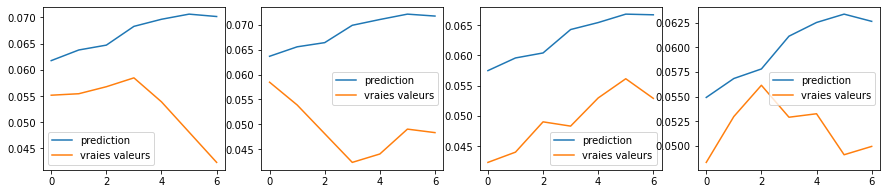

In [99]:
plt.figure(figsize=(15,3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.plot(prediction[i*3])
    plt.plot(y_test[i*3])
    plt.legend(["prediction","vraies valeurs"])
plt.show()


**Conclusion**


Les réultats ne sont pas satisfaisants pour la prédiction sur 7 jours. 
